## Load the data

In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise

from applefy.utils.fake_planets import add_fake_planets

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
# Background subtraction
psf_template_data = psf_template_data - np.min(psf_template_data)

## Create 3 stacks with different fake planets

In [4]:
config_file_a = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0071a.json"
config_file_b = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0142b.json"
config_file_c = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0190c.json"

In [5]:
with open(config_file_a) as json_file:
    fake_planet_config_a = json.load(json_file)
    
with open(config_file_b) as json_file:
    fake_planet_config_b = json.load(json_file)
    
with open(config_file_c) as json_file:
    fake_planet_config_c = json.load(json_file)

In [6]:
data_no_fake_planet = science_data

In [7]:
data_with_fake_planet_a = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config_a,
    scaling_factor=1.0)

In [8]:
data_with_fake_planet_b = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config_b,
    scaling_factor=1.0)

In [9]:
data_with_fake_planet_c = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config_c,
    scaling_factor=1.0)

# Test the validation for the different datasets

In [10]:
lambdas = np.logspace(1, 8, 200)

In [15]:
def test_dataset(dataset_in):
    
    #1.) Create the S4 model
    s4_model = S4(
        data_cube=dataset_in,
        parang=raw_angles,
        psf_template=psf_template_data,
        noise_noise_cut_radius_psf=4.0,
        noise_mask_radius=5.5,
        device=0,
        noise_lambda_init=1e3,
        planet_convolve_second=True,
        planet_use_up_sample=1,
        work_dir="/fast/mbonse/s4/70_results/02_fine_tuning/s4_lambda_test/",
        verbose=True)
    
    # 2.) Test the lambda values
    all_results, best_lambda = s4_model.validate_lambdas_noise(
        num_separations=20,
        lambdas=lambdas,
        num_test_positions=15,
        test_size=0.3,
        approx_svd=5000)
    
    return all_results, best_lambda

In [16]:
experiment_setups = [
    ("no planet", data_no_fake_planet),
    ("Planet a", data_with_fake_planet_a),
    ("Planet b", data_with_fake_planet_b),
    ("Planet c", data_with_fake_planet_c)]

Creating right reason mask ... [DONE]
Compute validation positions for separation 2.5238095238095237 ...
Setup training data for separation 2.5238095238095237 ...
Build normalization frames ... [DONE]
Compute betas for separation 2.5238095238095237 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 2.5238095238095237 ...
Compute validation errors for separation 2.5238095238095237 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 754.92it/s]


Compute validation positions for separation 5.0476190476190474 ...
Setup training data for separation 5.0476190476190474 ...
Build normalization frames ... [DONE]
Compute betas for separation 5.0476190476190474 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 5.0476190476190474 ...
Compute validation errors for separation 5.0476190476190474 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 758.19it/s]


Compute validation positions for separation 7.571428571428571 ...
Setup training data for separation 7.571428571428571 ...
Build normalization frames ... [DONE]
Compute betas for separation 7.571428571428571 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 7.571428571428571 ...
Compute validation errors for separation 7.571428571428571 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 796.54it/s]


Compute validation positions for separation 10.095238095238095 ...
Setup training data for separation 10.095238095238095 ...
Build normalization frames ... [DONE]
Compute betas for separation 10.095238095238095 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 10.095238095238095 ...
Compute validation errors for separation 10.095238095238095 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 749.22it/s]


Compute validation positions for separation 12.619047619047619 ...
Setup training data for separation 12.619047619047619 ...
Build normalization frames ... [DONE]
Compute betas for separation 12.619047619047619 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 12.619047619047619 ...
Compute validation errors for separation 12.619047619047619 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 725.38it/s]


Compute validation positions for separation 15.142857142857142 ...
Setup training data for separation 15.142857142857142 ...
Build normalization frames ... [DONE]
Compute betas for separation 15.142857142857142 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.78s/it]


Re-mask betas for separation 15.142857142857142 ...
Compute validation errors for separation 15.142857142857142 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 780.06it/s]


Compute validation positions for separation 17.666666666666664 ...
Setup training data for separation 17.666666666666664 ...
Build normalization frames ... [DONE]
Compute betas for separation 17.666666666666664 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 17.666666666666664 ...
Compute validation errors for separation 17.666666666666664 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 793.97it/s]


Compute validation positions for separation 20.19047619047619 ...
Setup training data for separation 20.19047619047619 ...
Build normalization frames ... [DONE]
Compute betas for separation 20.19047619047619 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 20.19047619047619 ...
Compute validation errors for separation 20.19047619047619 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 777.11it/s]


Compute validation positions for separation 22.714285714285715 ...
Setup training data for separation 22.714285714285715 ...
Build normalization frames ... [DONE]
Compute betas for separation 22.714285714285715 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 22.714285714285715 ...
Compute validation errors for separation 22.714285714285715 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 755.59it/s]


Compute validation positions for separation 25.238095238095237 ...
Setup training data for separation 25.238095238095237 ...
Build normalization frames ... [DONE]
Compute betas for separation 25.238095238095237 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 25.238095238095237 ...
Compute validation errors for separation 25.238095238095237 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 756.35it/s]


Compute validation positions for separation 27.76190476190476 ...
Setup training data for separation 27.76190476190476 ...
Build normalization frames ... [DONE]
Compute betas for separation 27.76190476190476 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 27.76190476190476 ...
Compute validation errors for separation 27.76190476190476 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 765.99it/s]


Compute validation positions for separation 30.285714285714285 ...
Setup training data for separation 30.285714285714285 ...
Build normalization frames ... [DONE]
Compute betas for separation 30.285714285714285 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 30.285714285714285 ...
Compute validation errors for separation 30.285714285714285 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 774.58it/s]


Compute validation positions for separation 32.80952380952381 ...
Setup training data for separation 32.80952380952381 ...
Build normalization frames ... [DONE]
Compute betas for separation 32.80952380952381 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 32.80952380952381 ...
Compute validation errors for separation 32.80952380952381 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 758.26it/s]


Compute validation positions for separation 35.33333333333333 ...
Setup training data for separation 35.33333333333333 ...
Build normalization frames ... [DONE]
Compute betas for separation 35.33333333333333 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 35.33333333333333 ...
Compute validation errors for separation 35.33333333333333 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 740.41it/s]


Compute validation positions for separation 37.857142857142854 ...
Setup training data for separation 37.857142857142854 ...
Build normalization frames ... [DONE]
Compute betas for separation 37.857142857142854 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 37.857142857142854 ...
Compute validation errors for separation 37.857142857142854 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 753.20it/s]


Compute validation positions for separation 40.38095238095238 ...
Setup training data for separation 40.38095238095238 ...
Build normalization frames ... [DONE]
Compute betas for separation 40.38095238095238 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 40.38095238095238 ...
Compute validation errors for separation 40.38095238095238 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 776.09it/s]


Compute validation positions for separation 42.904761904761905 ...
Setup training data for separation 42.904761904761905 ...
Build normalization frames ... [DONE]
Compute betas for separation 42.904761904761905 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 42.904761904761905 ...
Compute validation errors for separation 42.904761904761905 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 795.53it/s]


Compute validation positions for separation 45.42857142857143 ...
Setup training data for separation 45.42857142857143 ...
Build normalization frames ... [DONE]
Compute betas for separation 45.42857142857143 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 45.42857142857143 ...
Compute validation errors for separation 45.42857142857143 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 741.51it/s]


Compute validation positions for separation 47.95238095238095 ...
Setup training data for separation 47.95238095238095 ...
Build normalization frames ... [DONE]
Compute betas for separation 47.95238095238095 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 47.95238095238095 ...
Compute validation errors for separation 47.95238095238095 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 775.28it/s]


Compute validation positions for separation 50.476190476190474 ...
Setup training data for separation 50.476190476190474 ...
Build normalization frames ... [DONE]
Compute betas for separation 50.476190476190474 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 50.476190476190474 ...
Compute validation errors for separation 50.476190476190474 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 804.08it/s]


Recommended Lambda = 62949.89
Make sure to check if the tested range of lambda values is covering the global minimum!


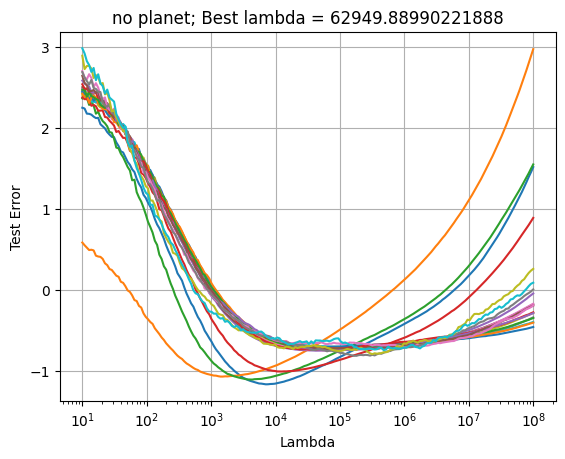

Creating right reason mask ... [DONE]
Compute validation positions for separation 2.5238095238095237 ...
Setup training data for separation 2.5238095238095237 ...
Build normalization frames ... [DONE]
Compute betas for separation 2.5238095238095237 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 2.5238095238095237 ...
Compute validation errors for separation 2.5238095238095237 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 721.44it/s]


Compute validation positions for separation 5.0476190476190474 ...
Setup training data for separation 5.0476190476190474 ...
Build normalization frames ... [DONE]
Compute betas for separation 5.0476190476190474 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 5.0476190476190474 ...
Compute validation errors for separation 5.0476190476190474 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 805.17it/s]


Compute validation positions for separation 7.571428571428571 ...
Setup training data for separation 7.571428571428571 ...
Build normalization frames ... [DONE]
Compute betas for separation 7.571428571428571 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:26<00:00,  5.77s/it]


Re-mask betas for separation 7.571428571428571 ...
Compute validation errors for separation 7.571428571428571 ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 798.37it/s]


Compute validation positions for separation 10.095238095238095 ...
Setup training data for separation 10.095238095238095 ...
Build normalization frames ... [DONE]
Compute betas for separation 10.095238095238095 ...


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 8/15 [00:51<00:45,  6.50s/it]


KeyboardInterrupt: 

In [17]:
for tmp_planet_name, tmp_dataset in experiment_setups:
    
    all_results, best_lambda = test_dataset(tmp_dataset)
    
    merged_results = np.array([i for i in all_results.values()])
    median_result = np.median(merged_results, axis=0)
    
    plt.plot(lambdas, np.array(merged_results).T)
    plt.xlabel("Lambda")
    plt.ylabel("Test Error")
    plt.xscale("log")
    plt.title(tmp_planet_name + "; Best lambda = " + str(best_lambda))
    plt.grid()
    plt.show()

In [22]:
mean_error = np.mean(np.array(merged_results), axis=0)

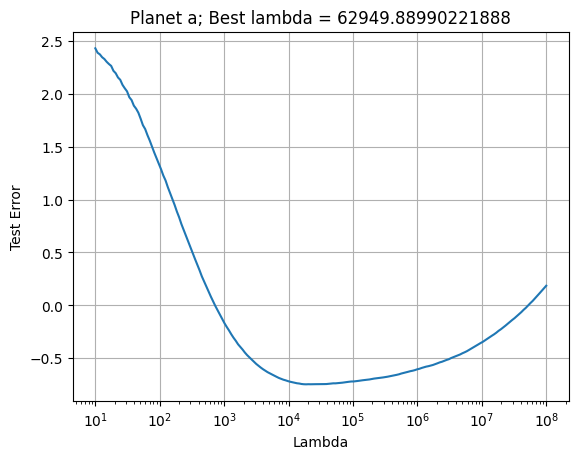

In [23]:
plt.plot(lambdas, mean_error)
plt.xlabel("Lambda")
plt.ylabel("Test Error")
plt.xscale("log")
plt.title(tmp_planet_name + "; Best lambda = " + str(best_lambda))
plt.grid()
plt.show()

In [24]:
lambdas[np.argmin(mean_error)]

18679.135990207847